<a href="https://colab.research.google.com/github/Satya-Ganta03/project-legato-/blob/main/Segmentation_apply.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, UpSampling2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image, ImageFilter
import numpy as np

from glob import glob
from tqdm import tqdm

In [ ]:
def iou_loss(y_true, y_pred):
    return 1-iou(y_true, y_pred)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum((y_true)) + K.sum((y_pred))
    jac = (intersection) / (sum_ - intersection)
    return jac

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

def segnet(input_size=(512, 512, 1)):

    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_size)

    # Encoding layer
    inp = Input(input_size)
    x = encoder.get_layer(name='block1_conv1')(inp)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block1_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block3_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block4_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = encoder.get_layer(name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = encoder.get_layer(name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)


    x = UpSampling2D()(x)
    x = Conv2D(1024, (3, 3), padding='same', name='deconv1')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (3, 3), padding='same', name='deconv2')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1024, (3, 3), padding='same', name='deconv3')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv4')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv5')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding='same', name='deconv6')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv7')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv8')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', name='deconv9')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, (3, 3), padding='same', name='deconv10')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', name='deconv11')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, (3, 3), padding='same', name='deconv12')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding='same', name='deconv13')(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(1, (3, 3), padding='same', name='deconv14')(x)
    x = Activation('sigmoid')(x)
    pred = Reshape((512,512))(x)

    return Model(inputs=inp, outputs=pred)

In [ ]:
model = segnet(input_size=(512,512,3))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, \
                      metrics=[iou, dice_coef, 'binary_accuracy'])
model.summary()

NameError: ignored

In [ ]:
model = load_model('/content/drive/MyDrive/CTScan/Seg_Model/1_segnet_lung_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
from PIL import Image
IMG = cv2.imread("/content/drive/MyDrive/CTScan/CovidData/COVID/Covid (1001).png")
img = cv2.resize(IMG, (512,512))
img = img / 255
img = img[np.newaxis, :, :, :]
pred = model.predict(img)

mask=np.squeeze(pred) > .5

im = Image.fromarray(mask)
im.save("/content/drive/MyDrive/CTScan/Pred/mask.png",format="png")
#cv2.imwrite('/content/drive/MyDrive/CTScan/Pred/mask.png',im)


1/1 [==============================] - 11s 11s/step


True

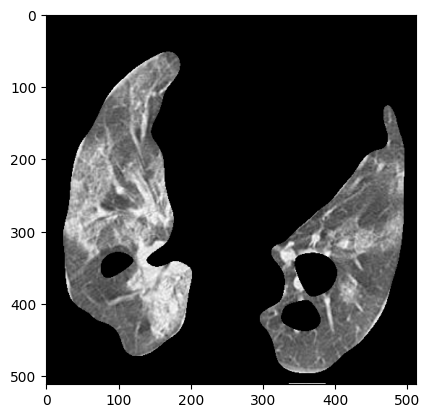

In [ ]:
image = cv2.imread("/content/drive/MyDrive/CTScan/CovidData/COVID/Covid (1001).png")
image=cv2.resize(image,(512,512))
mask = cv2.imread("/content/drive/MyDrive/CTScan/Pred/mask.png")
mask=mask[:,:,0]
masked = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(masked)
cv2.imwrite('/content/drive/MyDrive/CTScan/Pred/masked.png',masked)

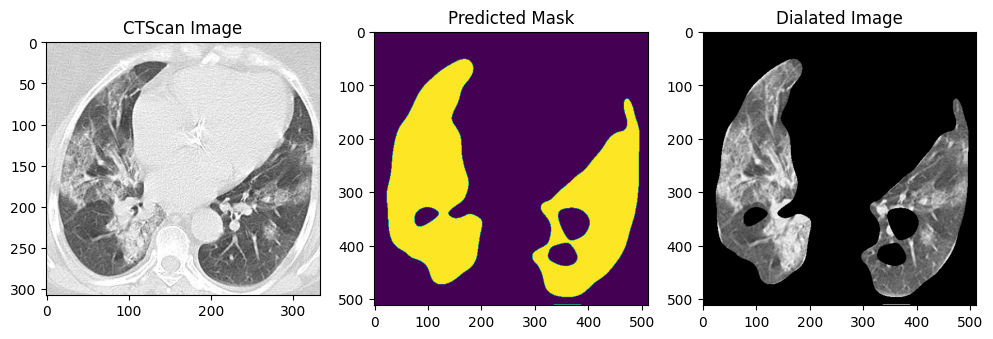

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(IMG)
plt.title('CTScan Image')
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('Predicted Mask')
plt.subplot(1,3,3)
plt.imshow(masked)
plt.title('Dialated Image')
plt.show()

In [ ]:
from PIL import Image
IMG = cv2.imread("/content/drive/MyDrive/CTScan/CovidData/non-COVID/Non-Covid (1003).png")
img = cv2.resize(IMG, (512,512))
img = img / 255
img = img[np.newaxis, :, :, :]
pred = model.predict(img)

mask=np.squeeze(pred) > .5

im = Image.fromarray(mask)
im.save("/content/drive/MyDrive/CTScan/Pred/maskv2.png",format="png")
#cv2.imwrite('/content/drive/MyDrive/CTScan/Pred/mask.png',im)


1/1 [==============================] - 0s 25ms/step


True

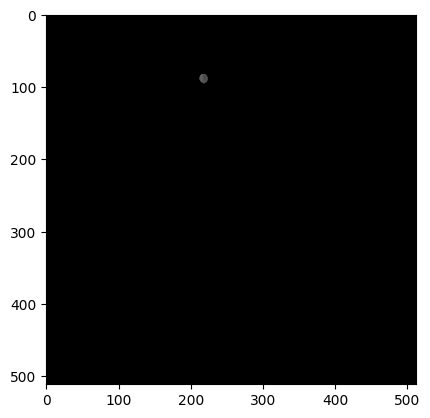

In [ ]:
image = cv2.imread("/content/drive/MyDrive/CTScan/CovidData/non-COVID/Non-Covid (1003).png")
image=cv2.resize(image,(512,512))
mask = cv2.imread("/content/drive/MyDrive/CTScan/Pred/maskv2.png")
mask=mask[:,:,0]
masked = cv2.bitwise_and(image, image, mask=mask)
plt.imshow(masked)
cv2.imwrite('/content/drive/MyDrive/CTScan/Pred/maskedv2.png',masked)

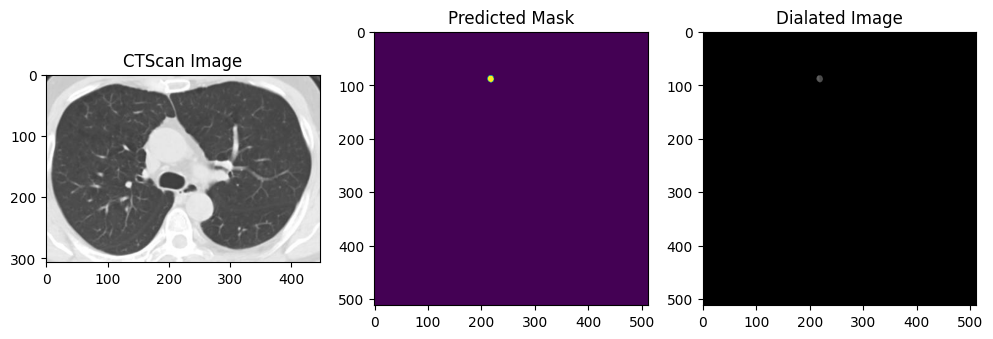

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(IMG)
plt.title('CTScan Image')
plt.subplot(1,3,2)
plt.imshow(mask)
plt.title('Predicted Mask')
plt.subplot(1,3,3)
plt.imshow(masked)
plt.title('Dialated Image')
plt.show()